In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.8 MB/s eta 0:00:00
Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

grayscale settings

In [4]:
path = untar_data(URLs.MNIST_SAMPLE)



downloading mnist data set for our training

In [5]:
Path.BASE_PATH = path

In [6]:
print(path)

/root/.fastai/data/mnist_sample


In [7]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

listing contents of mnist data set then the code below lists contents in training folder

In [8]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [9]:
threes = (path/'train/3').ls()
sevens = (path/'train/7').ls()

threes

(#6131) [Path('train/3/41007.png'),Path('train/3/36946.png'),Path('train/3/10666.png'),Path('train/3/2915.png'),Path('train/3/8882.png'),Path('train/3/9278.png'),Path('train/3/39741.png'),Path('train/3/17467.png'),Path('train/3/27047.png'),Path('train/3/47192.png')...]

we are separating the contents of the 'labels' to two different variables. Threes dataset and sevens. Thus each variable contains a list of the file paths of all the 3s, and 7s, and there are 6000 images roughly in each folder.

In [10]:
im3_path = threes[18]
im3 = Image.open(im3_path)
im3

In [11]:
im3_tensor = tensor(im3)

create a tensor object, a numeric representation of the image

In [12]:
data_frame = pd.DataFrame(im3_tensor[4:15,4:22])
data_frame.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,60,48,96,96,255,253,253,253,153,96,24,0,0
3,0,0,167,190,191,228,221,251,251,253,227,220,220,220,221,78,190,43
4,0,0,221,251,253,251,188,126,126,126,31,0,0,0,0,16,188,220
5,0,0,27,129,129,31,15,0,0,0,0,0,0,0,0,68,236,251
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60,228,251,211
7,0,0,0,0,0,0,0,0,0,0,0,0,24,194,255,181,79,0
8,0,0,0,0,0,0,0,0,0,32,151,190,205,231,161,16,0,0
9,0,0,0,0,0,0,0,0,0,253,251,251,251,94,0,0,0,0


we then created a data frame by slicing the tensor object of the image to a small section (rows 4-15, and colums 4-22), as well as setting the font size and background of the cells of the data frame

# 1. Our first model of image classification
### - calculating the mean of all the pixels


Now we are going to do our first model of distinguishing between 3 and a 7. We are purely going to determine the average numerical value of each pixel for each category (3 or 7). To do this we are going to create a stack of the tensors (going from 2d tensor to 3d tensor or 3d matrix or rank 3 tensor).

In [13]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

len(seven_tensors), len(three_tensors)



(6265, 6131)

In the above code we created a list of tensor objects for each image in each category. 6k images for each category roughly.

<Axes: >

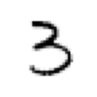

In [14]:
show_image(three_tensors[0])


In [15]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255



What we did here is create a rank 3 tensor by stacking all of the 2d tensors together in each of the categories. We need to convert this to a float if we want pytorch to calculate the mean. Also, since pixel values are large (between 0 and 255) we want to normalize this by dividing by the largest pixel value, creating values between 0 and 1.

In [16]:
stacked_sevens.size()

torch.Size([6265, 28, 28])

the size or shape is the size of each axis of the tensor. 6265 images of 28 rows and 28 colums of pixels.

In [17]:
len(stacked_sevens.size())

3

This is the number of elements in a specific axis. 3 elements is a rank 3 tensor.

<Axes: >

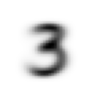

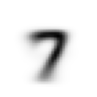

In [18]:
mean3 = stacked_threes.mean(0)
mean7 = stacked_sevens.mean(0)

show_image(mean3)
show_image(mean7)

By taking the mean along dimension 0, we effectively average out the pixel values across all images and obtain a single representative image that captures the common features or characteristics of the digit 3.

##Baseline Model - Mean value of pixels

We are going to use two approaches:

1. Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). **This is called the mean absolute difference or L1 norm**

2. Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). **This is called the root mean squared error (RMSE) or L2 norm.**

<Axes: >

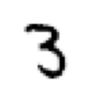

In [19]:
arb_3 = stacked_threes[9]
show_image(arb_3)

In [20]:
l1_norm_3 = (arb_3-mean3).abs().mean()

l2_norm_3 = ((arb_3 - mean3)**2).mean().sqrt()

l1_norm_3, l2_norm_3


(tensor(0.1163), tensor(0.2118))

In [21]:

l1_norm_7 = (arb_3-mean7).abs().mean()

l2_norm_7 = ((arb_3 - mean7)**2).mean().sqrt()

l1_norm_7, l2_norm_7

(tensor(0.1564), tensor(0.3007))

In both cases the l1 and l2 normal is smaller when comparing to "ideal 3" and the baseline model would accurately guess the right number.

In [22]:
F.l1_loss(arb_3.float(), mean7), F.mse_loss(arb_3.float(), mean7).sqrt()

(tensor(0.1564), tensor(0.3007))

Pytorch already includes l1_loss and mean square error as loss functions, and is accessible with F in fastai framework

### Working with tensors and numpy arrays

1. Numpy arrays is a multidimensional table of data **of the same type.** you can have an array of arrays, and the indices can be various sizes (called a jagged array).  These structures can't be loaded onto gpus.

2. Tensors are similar to numpy arrays but with more restrictions. The type has to be a simple numeric type, has to be uniform for each index (no jaggedness), a regular shaped rectangular structure. One bonus is that these tensor structures can live on the gpu which unlocks faster computation. Without this deep learning isnt possible.



In [23]:
data = [[1,2,3],[4,5,6]]

arr = array(data)

tns = tensor(data)

arr

array([[1, 2, 3],
       [4, 5, 6]])

In [24]:
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

In [25]:
tns[:,1]

tensor([2, 5])

The first element before the comma refers to rows, the element after the comma refers to the column

The single colon means we want to include all rows, the 1 indicates we want the 2nd column only

In [26]:
tns[1,1:3]

tensor([5, 6])

Here we just want the second row, and include the 2nd number up until but not including the 3rd item.

In [27]:
tns + 1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [28]:
tns.type()

'torch.LongTensor'

And will automatically change type as needed, for example from `int` to `float`:

In [29]:
tns * 1.50

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

In [30]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

In [31]:
valid_3_stack = torch.stack([tensor(Image.open(o)) for o in (path/'valid/3').ls()])
valid_7_stack = torch.stack([tensor(Image.open(o)) for o in (path/'valid/7').ls()])

valid_3_stack = valid_3_stack.float()/255
valid_7_stack = valid_7_stack.float()/255

valid_3_stack.shape, valid_7_stack.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

So here we create a rank 3 tensor which is a stack of all the tensor objects representing 3s and 7s in the validation set. Then we normalize the stack and lastly display the dimensions

In [32]:
def mnist_dist(a,b): return (a-b).abs().mean((-1,-2))

Here we are defining a function that calculates the l1 norm between two values (in this case tensors). -1, -2 is negative indexing, so we want the last and 2nd last dimensions to be calculated in the mean.

-1,-2 must be passed as a tuple, which means encased in brackets. Otherwise it will process it as two separate integers instead of a tuple.

In [33]:
mnist_dist(arb_3, mean3)

tensor(0.1163)

This is the average distance between each pixel between the arbritary image and the 'ideal' image.

But in ML we want to determine the overall accuracy, that is by calculating this average distance from the 'ideal image' for all images in the validation set. How much we do this?

1. We could create a loop to loop over all items in the validation set and calculate the l1 norm, sum it, then divide by the number of items in the validation set. But there is a simpler way.

2. What happens when we use the l1 norm function and we pass a rank 3 tensor and a rank 2 tensor for values a and b

- mnist_distance(rank 3, rank 2)

- mnist_distance(valid_3_tens, mean3)

In [34]:
valid_3_l1norm = mnist_dist(valid_3_stack, mean3)

valid_3_l1norm, valid_3_l1norm.shape

(tensor([0.1135, 0.1455, 0.1678,  ..., 0.1282, 0.1419, 0.1814]),
 torch.Size([1010]))

Instead of complaining about shapes not matching, it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set). How did that happen?

Take another look at our function mnist_distance, and you'll see we have there the subtraction (a-b). The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use broadcasting. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

In [35]:
(valid_3_stack - mean3).size()

torch.Size([1010, 28, 28])

As you see when you subtract rank 2 tensor from rank 3 tensor it broadcasts the rank 2 tensor to make copies (1k copies) to match the width of the rank 3 tensor. Then performs the calculation  as normal.

Now lets define a function that determines wether an arbritrary number is 3 or not.

This compares the l1 norm of the arbritrary image and 'ideal 3', and the l1 norm of the arbritrary image and 'ideal 7'. If the l1 norm is smaller in the former then it is most likely 3

In [36]:
def is3(x): return mnist_dist(x,mean3) < mnist_dist(x,mean7)

is3(arb_3), is3(arb_3).float()

(tensor(True), tensor(1.))

returns true, and taking the float we see that it returns 1

In [37]:
is3(stacked_threes)

tensor([ True,  True,  True,  ..., False,  True,  True])

thanks to broadcasting we can do this calculation for all of the tensors in the validation set for 3.

In [38]:
accuracy_3s = is3(stacked_threes).float().mean()

accuracy_7s = (1 - is3(stacked_sevens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2


(tensor(0.8912), tensor(0.9962), tensor(0.9437))

We have successfully calculated a metric in ML, which is a function to determine the accuracy of our model. Our model is roughly 90% accurate for the validation set.

In this case we determined how accurate we were on average in categorizing each image in the validation set.

The next step is upgrading the baseline to a system that automatically modifies itself to improve its performance. In other words, it's time to talk about the training process, and SGD.

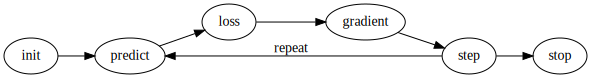

In [39]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

### Steps in training a model

####initialize
1

- We first initialize the weights of our model using small random numbers. This is only done in the beginning of the training (first epoch).

####prediction

2. - The model then makes a prediction based on the data and the current weights of the base model. First pass has random weights so accuracy will be poor.

####loss function

3. - A loss function is then used to measure the difference between the first prediction and the actual value. We want to minimize this loss function.

####gradient calculation

4. - We could use a manual approach of adding a small value to the weights in the loss function and see if the prediction is better. This is **numerical differentiation** and its a more tedious process. You adjust each weight manually and see how much the loss changes. This gives you an approximation of the gradient.
    - this is computationally expensive since you are calculating the loss for each weight in the model for each step, until you reach an optimum.
  - Or you can get the exact value of the gradients by using **back propogation** which is sort of like the derivative for each weight.

####gradient descent - learning step

5. - We update the weights based on the gradient, often with an optimization algorithm like stochastic gradient descent. This algorithm multiplies the gradient by a small amount (learning rate), subtract this from the current weight to get the new weight.

####repeat

6. - We go back to step 2 and repeat the process, using the new weights to make predictions. With each pass, the model's predictions should get better and the loss should decrease.


####optima

7. - we stop at the optima, when the model fails to improve or we arrive at our desired number of epochs (passes)

# Stochastic Gradient Descent


Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and x is a weight parameter of the function:

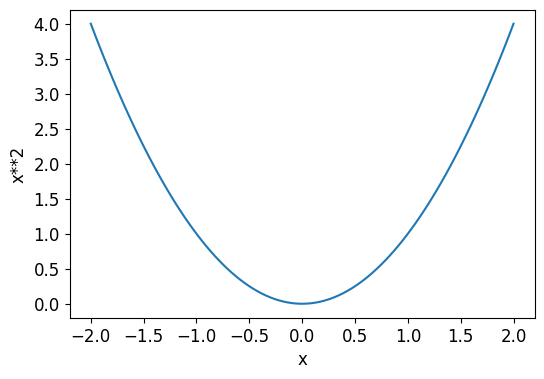

In [40]:
def f(x): return x**2

plot_function(f, 'x', 'x**2')

select a random value for the parameter and determine the loss

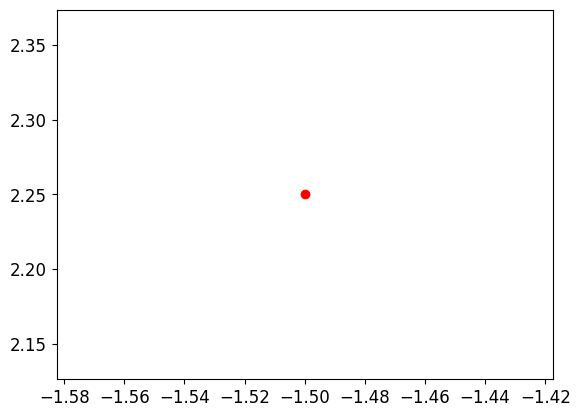

In [41]:
plt.scatter(-1.5, f(-1.5), color='red');

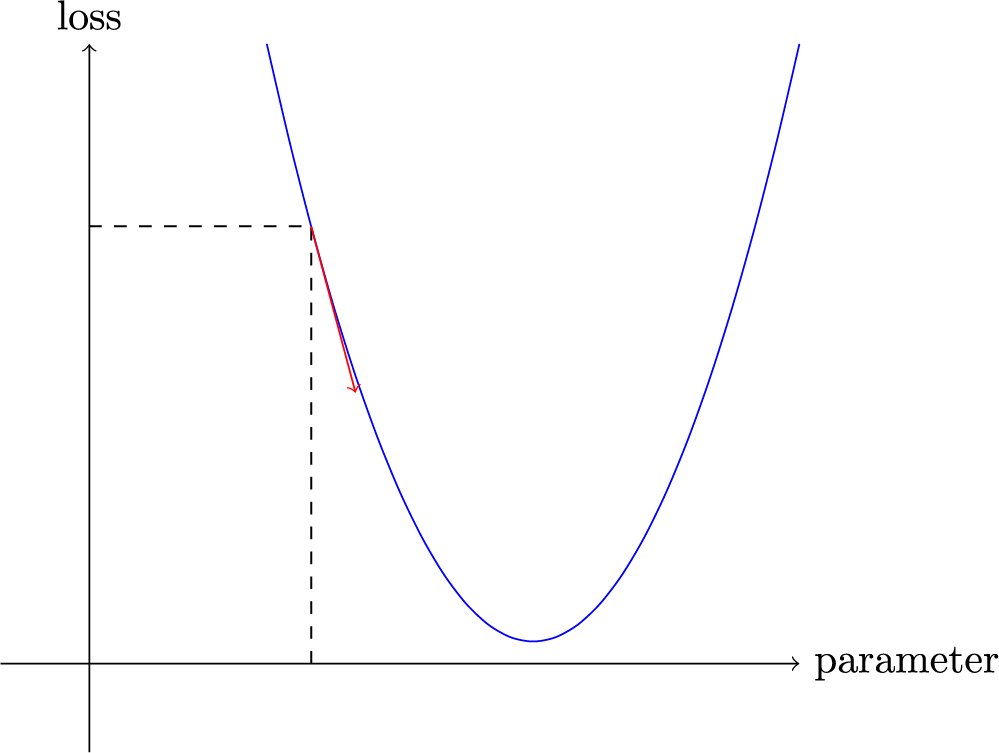

We can change our weight by a little in the direction of the slope, calculate our loss and adjustment again, and repeat this a few times. Eventually, we will get to the lowest point on our curve:

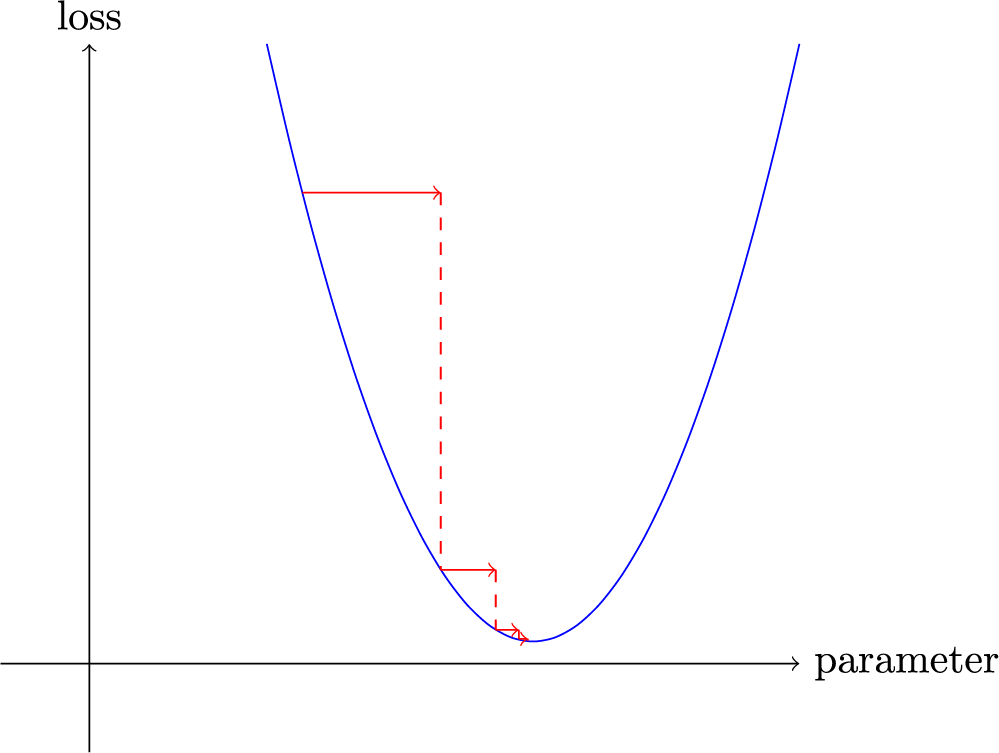

However instead of doing this manually we can calculate the derivative. We use calculus as a performance optimization; it allows us to more quickly calculate whether our loss will go up or down when we adjust our parameters up or down.

In other words, the gradients will tell us how much we have to change each weight to make our model better.

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative, we won’t get back one number, but lots of them—a gradient for every weight.

In [42]:
xt = tensor(3.).requires_grad_()
xt

tensor(3., requires_grad=True)

so we create a rank 1 tensor.
- Note In PyTorch, every tensor has a Boolean property called requires_grad. If requires_grad=True, PyTorch will track, on this tensor, all the operations that are being done. Then, during backpropagation, PyTorch will compute the gradients of the loss with respect to this tensor.

This is important because in a neural network, not all tensors need to have their gradients computed. For instance, the inputs to the network (your data) don't need to have gradients computed because these values aren't updated during training – only the weights of the model are. So, you would set requires_grad=True for the weights of your model.

In [43]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

loss function with respect to tensor

In [44]:
yt.backward()


calculates the derivative or gradients for each weight or parameter, called backpropogation.

In [45]:

xt.grad

tensor(6.)

The gradient of the parameter is 2x which is the derivative of the loss function of x**2

Now apply the same process with vectors

In [46]:
xt = tensor([2.,3.,5.,6.]).requires_grad_()
xt


tensor([2., 3., 5., 6.], requires_grad=True)

And we'll add `sum` to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

In [47]:
def f(x): return (x**2).sum()
yt = f(xt)
yt

tensor(74., grad_fn=<SumBackward0>)

In [48]:
yt.backward()


In [49]:
xt.grad

tensor([ 4.,  6., 10., 12.])

The gradients only tell us the slope of our function, they don't actually tell us exactly how far to adjust the parameters. But it gives us some idea of how far; if the slope is very large, then that may suggest that we have more adjustments to do, whereas if the slope is very small, that may suggest that we are close to the optimal value.

##Stepping with learning rate, optimizer step



So when we talk about minimizing the loss function, what we are looking for is the local minimum of the loss function. This is where the error in our prediction is the least with respect to the actual value. To find this local minimum we need to do gradient descent. We need to go against the gradient and find where the slope is 0.

The learning rate is between 0.001 and 0.1. Some people use algorithms to find this learning rate, but some people try a few different numbers to see which is best. Once we find a learning rate, we update the weight or bias as follows



```
w -= gradient(w) * lr
```



This is known as stepping your parameters, using an optimizer step. Notice how we subtract the gradient * lr from the parameter to update it. We are going against the gradient which means updating the parameters in the direction that decreases the loss function the fastest.

If your learning rate is too large you will overshoot, and bounce around; similarily if the learning rate is too small you will be doing too many calculations.

# End to end Stochastic gradient descent

Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [50]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

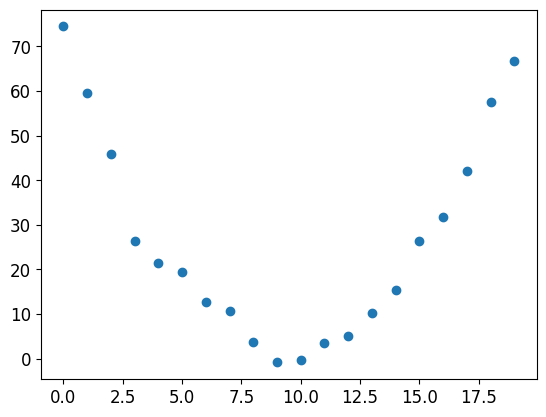

In [51]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed)

How the speed was generated with arbritrary noise to simulate measurements in real world (since friction would cause non uniform parabola)

1. First, the parabolic function 0.75*(time-9.5)**2 is calculated. This results in a tensor (let's call it parabola) that represents a parabola centered at time = 9.5.

2. Then, the random noise torch.randn(20)*3 is generated. This results in a tensor of the same size (let's call it noise) that contains 20 random numbers, each drawn from a normal distribution with a mean of 0 and a standard deviation of 3.

3. These two tensors parabola and noise are added together, element-wise. This means that the first element of parabola is added to the first element of noise, the second element of parabola is added to the second element of noise, and so on.

4. Finally, the scalar 1 is added to each element of the r4. esulting tensor.

Great we plotted some values, now lets try to fit this data to a prediction model.

In [52]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

This greatly simplifies the problem, since every quadratic function is fully defined by the three parameters a, b, and c. Thus, to find the best quadratic function, we only need to find the best values for a, b, and c. **These are our weights.**

Now we need to determine a loss function so we will use MSE

In [53]:
  def mse(predict, actual): return ((predict - actual)**2).mean()

#7 steps in training model

We have our loss function, our data, now we go through the 7 steps to train a model.

###Initialize the params

In [54]:
params = torch.randn(3).requires_grad_()

In [55]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

In [56]:
original_params = params.clone()

In [57]:
prediction = f(time, params)

In [58]:
prediction

tensor([ 1.3525e+00, -1.6391e-01, -3.2121e+00, -7.7919e+00, -1.3903e+01, -2.1547e+01, -3.0721e+01, -4.1428e+01, -5.3666e+01, -6.7436e+01, -8.2738e+01, -9.9571e+01, -1.1794e+02, -1.3783e+02,
        -1.5926e+02, -1.8222e+02, -2.0671e+02, -2.3274e+02, -2.6029e+02, -2.8938e+02], grad_fn=<AddBackward0>)

This is the function of our model with random params, we will subsequently train this model to fit the actual data better by minimizing the loss, using gradient descent.

Lets create a function that plots the actual values, and the predicted values.


In [59]:
def actual_vs_prediction(time, speed, prediction):
  # If preds requires gradients, detach it before converting to numpy
  # since our prediction function or model has params which require gradients
  # we need to convert from tensor to numpy just to plot the output of prediction model
    if prediction.requires_grad:
      prediction = prediction.detach()
    plt.scatter(time,speed,color='blue',label='actual')
    plt.scatter(time,prediction,color='red',label='prediction')
    plt.ylim(-300,100)
    plt.legend()
    plt.show()


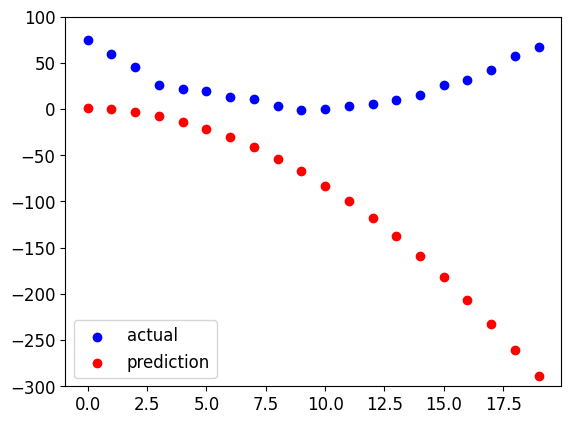

In [60]:
actual_vs_prediction(time,speed,prediction)

This model doesn't accurately model the actual values so lets calculate the loss.

##Calculate the loss and gradient values


In [61]:
loss = mse(prediction,speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)

calculate gradient values of the model (a,b,c)

In [62]:
loss.backward()

In [63]:
params.grad

tensor([-53195.8633,  -3419.7148,   -253.8908])

## learning rate and step, update gradients

In [64]:
  lr = 1e-5


In [65]:
params.data = params.data - lr * params.grad.data

lets see if loss improved

In [66]:
prediction = f(time,params)
mse(prediction,speed)

tensor(5435.5356, grad_fn=<MeanBackward0>)

Awesome 30% improvement. lets plot this.

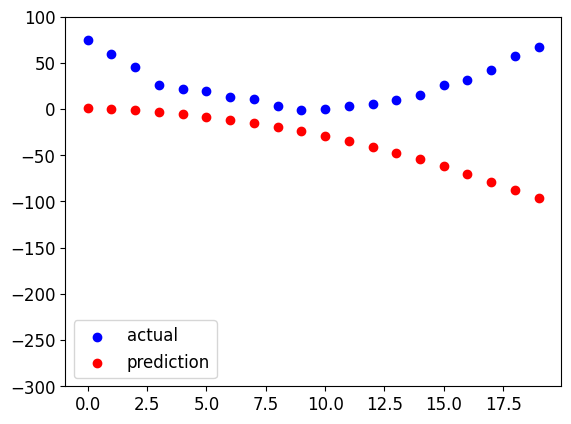

In [67]:
actual_vs_prediction(time,speed,prediction)

lets automate this

In [68]:
def apply_step(params, prn=True):
  prediction = f(time,params)
  loss = mse(prediction, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None #remove gradient values so it can be recalculated in next step
  if prn: print(loss.item()) #item prints the value of the loss tensor object
  return prediction


In [69]:
for i in range(10):
  apply_step(params)

5435.53564453125
4227.6611328125
1348.8753662109375
804.1176147460938
701.029296875
681.5181884765625
677.8226318359375
677.11962890625
676.9830322265625
676.9537353515625


We see that the loss is going down considerably after 10 epochs.

In [70]:
original_params

tensor([-0.7658, -0.7506,  1.3525], grad_fn=<CloneBackward0>)

In [71]:
params

tensor([ 0.1758, -0.6895,  1.3591], requires_grad=True)

we see our original params is a clone of params, so we need to detach it to just get its values, then add require_gradient flag so we can calculate the gradients in the apply_step function.

Lets make a new variable called old_params and which is the initial param values we calculated at the start. We will do the training again and look at the change over time.

In [72]:
old_params = original_params.detach().requires_grad_()

25823.80859375


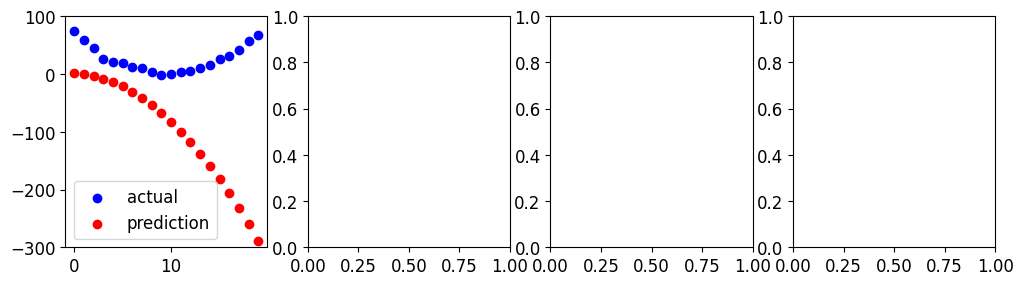

5435.53564453125


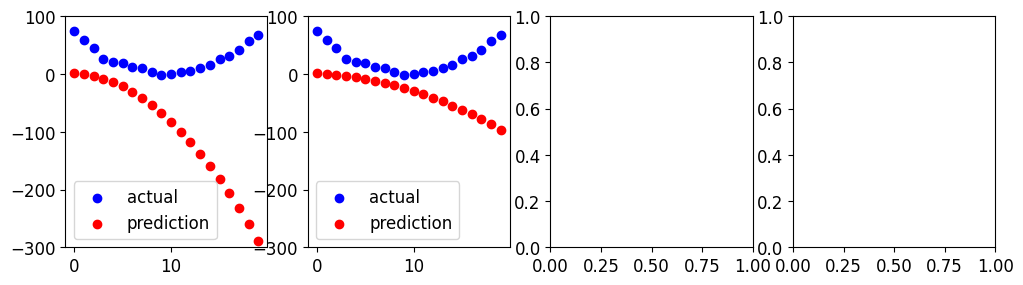

1577.44921875


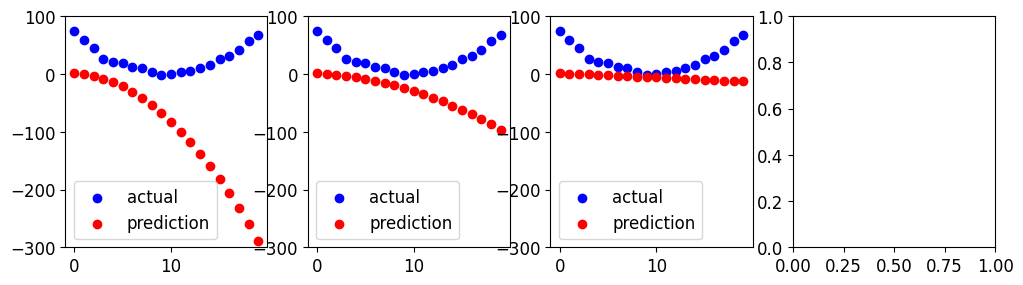

847.3778076171875


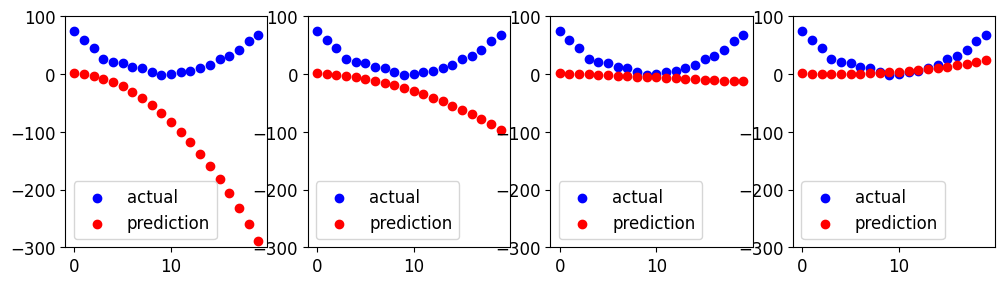

<Figure size 640x480 with 0 Axes>

In [73]:
_, axs = plt.subplots(1, 4, figsize=(12, 3))

for ax in axs:
    preds = apply_step(old_params, True)
    plt.sca(ax)
    actual_vs_prediction(time, speed, preds)

plt.tight_layout()

There you have it, we showed a visual representation of the model's loss function minimizing overtime, and the model trying to fit the data over time

# MNIST loss function

We already have our independent variables x—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor)

When working with images in neural networks, it's common to flatten the input data because it simplifies the design and architecture of the model. This is especially true in basic or fully-connected neural networks (also known as dense networks), where each neuron in one layer is connected to every neuron in the next layer.

Flattening doesn't really lose any information, because the pixel values are still there in the same order, but the spatial relationships between pixels are not explicitly preserved. It's a tradeoff for the simplicity of the model. However, for tasks where spatial relationships are important (such as many computer vision tasks), other types of layers and architectures that preserve and utilize this spatial information (like convolutional neural networks) are commonly used.

We can do this using view, which is a PyTorch method that changes the shape of a tensor without changing its contents. -1 is a special parameter to view that means "make this axis as big as necessary to fit all the data":

In [74]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_x[20]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,


We need labels for our images, so we use 1 for 3, and 0 for 7

In [75]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

so we have an ordered list of labeling all threes with 1, and all 7s with 0, and the length of this matrix is the amount of all 3s and 7s images.

Suppose train_x denoted above, which has 6000ish 'three' images and 6000 'seven' images concatenated to one matrix, then train_y will be 12000 units long (first 6000 elements will be 1s (threes), and the second 6000 will be 0s.)



In [76]:
print(train_y)
print(train_y.shape)

tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])
torch.Size([12396, 1])


A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function which, when combined with list, provides a simple way to get this functionality:

In [77]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

here we combined the true label with each image.

Below is just all of the previous steps put together to see visually

In [78]:
valid_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_stack) + [0]*len(valid_7_stack)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel

1.   List item
2.   List item

(this is the *initialize* step in our seven-step process):

In [79]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [80]:
weights = init_params((28*28,1))

The function weights x pixels won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0). You might remember from high school math that the formula for a line is y=w*x+b; we still need the b. We'll initialize it to a random number too:

In [81]:
bias = init_params(1)
bias

tensor([0.6863], requires_grad=True)

Now we can calculate the prediction for one image

In [82]:
(train_x[0]*weights.T).sum() + bias

tensor([7.9347], grad_fn=<AddBackward0>)

While we could use a Python for loop to calculate the prediction for each image, that would be very slow. Because Python loops don't run on the GPU, and because Python is a slow language for loops in general, we need to represent as much of the computation in a model as possible using higher-level functions.

In this case, there's an extremely convenient mathematical operation that calculates w*x for every row of a matrix—it's called matrix multiplication.

In Python, matrix multiplication is represented with the @ operator. Let's try it:

In [83]:
def linear1(xb): return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[ 7.9347],
        [23.3466],
        [18.9617],
        ...,
        [30.0539],
        [24.6363],
        [ 9.9163]], grad_fn=<AddBackward0>)

This is just the first pass. We will tune the weights.


Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0.0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:





In [84]:
corrects = (preds>0.0).float() == train_y


In [85]:
corrects.float().mean().item()

0.4912068545818329

Now let's see what the change in accuracy is for a small change in one of the weights (note that we have to ask PyTorch not to calculate gradients as we do this, which is what with torch.no_grad() is doing here):

In [86]:
with torch.no_grad(): weights[0] *= 1.0001

In [87]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

As you see, we need gradients to determine which direction we go to ultimately reach the smallest loss.

- we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.

- Unfortunately, we have a significant technical problem here. The gradient of a function is its slope, or its steepness, which can be defined as rise over run—that is, how much the value of the function goes up or down, divided by how much we changed the input. We can write this in mathematically as: (y_new - y_old) / (x_new - x_old).

    - y_old is the loss (or metric like accuracy) calculated from the predictions generated by your model using the current weights and biases (x_old).

    - x_old are the current values of your model's parameters (weights and biases).

    - x_new are the new values of your model's parameters after a small step has been applied.

    - y_new is the loss (or metric) calculated from the predictions generated by your model using these new parameters (x_new).

- since we defined earlier positive means 3, and negative means 7, if our loss gradient is y_new - y_old / x_new - x_old, and our accuracy is (y_new - y_old / x_new - x_old) > 0 == valid y, accuracy is binary either 1 or 0.

For small changes in the weights (the x values in the gradient formula), the accuracy  often doesn't change because the prediction (y value in the gradient formula) is still on the same side of the threshold (0 in this case).

This inability to provide a useful gradient for most changes in the weights is what makes accuracy a poor choice as a loss function when training models via methods like stochastic gradient descent.

Instead, we need a loss function which, when our weights result in slightly better predictions, gives us a slightly better loss. So what does a "slightly better prediction" look like, exactly? Well, in this case, it means that if the correct answer is a 3 the score is a little higher, or if the correct answer is a 7 the score is a little lower.

Let's write such a function now. What form does it take?

- The loss function receives not the images themselves, but the predictions from the model. Let's make one argument, prds, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor), indexed over the images.

- The purpose of the loss function is to measure the difference between predicted values and the true values — that is, the targets (aka labels). Let's make another argument, trgts, with values of 0 or 1 which tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor), indexed over the images.

In [88]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

Here we define a loss function that takes a sum of differences between the predicion and the label. However our predictions are negative and positive numbers...

The sigmoid function always outputs a number between 0 and 1. It's defined as follows:

1. `def sigmoid(x): return 1/(1+torch.exp(-x))`

Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1.


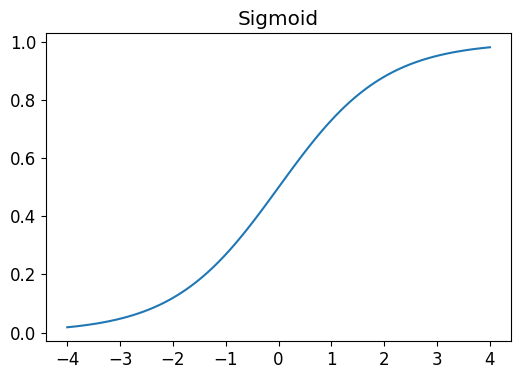

In [89]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

As you can see, it takes any input value, positive or negative, and smooshes it onto an output value between 0 and 1. It's also a smooth curve that only goes up, which makes it easier for SGD to find meaningful gradients.

Let's update mnist_loss to first apply sigmoid to the inputs:

In [90]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. All that is required is that a higher prediction corresponds to higher confidence an image is a 3.




#Minibatching

Rather than using the whole dataset or a single data item to calculate the loss, which could be computationally expensive or yield imprecise gradients respectively, a compromise is employed: the loss is computed over a small subset of data, known as a mini-batch.

The size of the mini-batch, or batch size, influences the accuracy of the gradient estimate and computational efficiency. A larger batch size offers a more accurate gradient but takes longer to process, and the memory constraints of accelerators such as GPUs must be considered.

Moreover, to improve model generalization, the selection of data items for each mini-batch is varied, typically by shuffling the dataset every epoch before creating mini-batches. This entire process is facilitated by utilities such as PyTorch's and fastai's DataLoader.

In [91]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [92]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 7, 24, 17, 21,  5, 19]), ('h', 'y', 'r', 'v', 'f', 't')),
 (tensor([ 9, 15, 14,  4, 16,  0]), ('j', 'p', 'o', 'e', 'q', 'a')),
 (tensor([22, 13, 25,  3,  2, 11]), ('w', 'n', 'z', 'd', 'c', 'l')),
 (tensor([12, 23,  1, 10,  8, 20]), ('m', 'x', 'b', 'k', 'i', 'u')),
 (tensor([18,  6]), ('s', 'g'))]

# Putting it all together, digit classifier

We are now ready to write our first training loop for a model using SGD!


For each epoch we will be effectively:

```
for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr
    
```

first lets reinitialize our params

In [93]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

weights = init_params((28*28,1))
bias = init_params(1)

weights[0]

tensor([-1.4020], grad_fn=<SelectBackward0>)

A `DataLoader` can be created from a `Dataset`:

In [94]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
dset = list(zip(train_x,train_y))

dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

we will do the same for valid dset

In [95]:
valid_x = torch.cat([valid_3_stack, valid_7_stack]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_stack) + [0]*len(valid_7_stack)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

valid_dl = DataLoader(valid_dset, batch_size=256)

In [96]:
len(valid_dset)

2038

**Let**'s create a mini-batch of size 4 for testing:

In [97]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [98]:
def linear1(xb): return xb@weights + bias

In [99]:
prediction = linear1(batch)
prediction

tensor([[ -5.3285],
        [-19.8220],
        [-12.4695],
        [-12.8993]], grad_fn=<AddBackward0>)

In [100]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() #bound predictions between 0 and 1
    return torch.where(targets==1, 1-predictions, predictions).mean()



In [101]:
loss = mnist_loss(prediction,train_y[:4])
loss

tensor(0.9988, grad_fn=<MeanBackward0>)

In [102]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0001), tensor([-0.0012]))

lets put this in a function...

In [103]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

and test...

In [104]:
calc_grad(train_x[:4],train_y[:4],linear1)

In [105]:
weights.grad.mean(),bias.grad

(tensor(-0.0003), tensor([-0.0024]))

The gradients will change each time since the gradients are additive after each epoch, we need to initialize them to 0 each epoch

In [106]:
weights.grad.zero_()
bias.grad.zero_();

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the `data` attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [107]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [108]:
prediction

tensor([[ -5.3285],
        [-19.8220],
        [-12.4695],
        [-12.8993]], grad_fn=<AddBackward0>)

In [109]:
(prediction>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

This gives us something to calculate accuracy, positive is 3, negative is 7, put it through a sigmoid and our midpoint becomes 0.5

In [110]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

check if it works

In [111]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

we are completely false in our prediction so this makes sense, lets improve this.

lets now make a validate epoch function


In [112]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

validate_epoch(linear1)

0.2875

thats our accuracy over all the mini batches in dataloader, lets start improving this, since this is a 30% accuracy our first starting point

In [113]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.5563

and a few more...

In [114]:
for i in range(10):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.6591 0.8437 0.9081 0.9335 0.9443 0.953 0.9574 0.9633 0.9653 0.9667 

# Creating an optimizer
## using pre-built classes

we will use ** nn.Linear** which does the same thing as our init_params and linear1 (xb@w + bias) together.

- It contains both the weights and biases in a single class. Here's how we replicate our model from the previous section:

In [115]:
linear_model = nn.Linear(28*28,1)
params = linear_model.parameters()
lol = list(params)
lol

[Parameter containing:
 tensor([[-2.4638e-02,  2.6699e-02,  5.8678e-03, -9.1850e-03, -1.8220e-02,  1.2362e-02, -2.1389e-02,  1.6938e-02,  1.9488e-02,  2.1922e-02,  9.3299e-03, -3.1263e-02,  2.5690e-02, -1.1079e-02,
          -1.0558e-02, -3.8371e-03,  2.6112e-02,  2.7462e-02,  5.5147e-03,  1.7041e-02, -3.3286e-02,  8.4366e-05, -3.1596e-02,  1.2155e-02, -2.5445e-02, -1.2729e-02,  2.4965e-02,  3.4132e-02,
          -2.1442e-02, -1.9822e-02,  4.4231e-03,  1.4039e-02, -5.8169e-03, -1.1153e-02, -2.3459e-02,  1.5246e-02,  3.4991e-02, -1.7289e-02,  1.6845e-02,  1.7443e-02,  2.8707e-02, -4.0662e-03,
           1.1249e-03,  2.6239e-02,  2.2575e-02,  3.5275e-02, -1.0235e-02,  1.4132e-02,  2.4938e-02, -2.4243e-02,  7.0950e-03, -7.9912e-03,  2.2958e-02, -1.6040e-02,  2.5049e-03,  2.1368e-02,
          -3.2718e-02, -3.0156e-02, -1.8292e-02,  2.2908e-02,  2.3947e-02, -2.4392e-02,  6.8103e-03, -1.8924e-02, -1.6577e-02,  3.0801e-02,  1.7250e-02, -9.7672e-03,  5.2572e-03,  6.9199e-03,
           8.3658

In [116]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

creating an optimizer

In [117]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

now init optimizer, remember we set lr earlier to 1

In [118]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

---



In [119]:
linear_model = nn.Linear(28*28,1) #init params
opt = BasicOptim(linear_model.parameters(), lr) #init optimizer


In [120]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step() #optimizer does step
        opt.zero_grad() #optimizer resets grad to 0

---


remember that dl is our data loader, which chunks the dataset of all 3s and 7s into 256 sized chunks, which is more manageable to train per epoch, and we randomize the dl per epoch so we get new 256 sample each time (to ensure the model doesn't learn patterns based on the order of the samples).

In [121]:
validate_epoch(linear_model)

0.5802

So now lets make a function that can iterate this process over a desired amount of epochs

In [122]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [123]:
train_model(linear_model, 20)

0.4932 0.7666 0.8638 0.9194 0.936 0.9521 0.9614 0.9658 0.9678 0.9692 0.9707 0.9736 0.9736 0.9741 0.9746 0.9766 0.9771 0.978 0.979 0.979 

---

fastai provides the SGD class which, by default, does the same thing as our BasicOptim:

---



In [124]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.6919 0.8662 0.9189 0.939 0.9521 0.9619 0.9663 0.9668 0.9692 0.9697 0.9731 0.9736 0.9736 0.9746 0.9756 0.9771 0.978 0.979 0.979 

fastai also provides Learner.fit, which we can use instead of train_model. To create a Learner we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

In [125]:
dls = DataLoaders(dl, valid_dl)

To create a `Learner` without using an application (such as `vision_learner`) we need to pass in all the elements that we've created in this chapter: the `DataLoaders`, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [126]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call fit:

In [127]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636234,0.501833,0.495584,00:00
1,0.304023,0.302504,0.697743,00:00
2,0.119999,0.151299,0.863592,00:00
3,0.057888,0.096274,0.918548,00:00
4,0.034823,0.071626,0.936212,00:00
5,0.025734,0.057953,0.950932,00:00
6,0.021871,0.049443,0.961236,00:00
7,0.020020,0.043833,0.966143,00:00
8,0.018975,0.039922,0.967615,00:00
9,0.018269,0.037037,0.969087,00:00


As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.

# Non linearity - neural networks

So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [128]:
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

A neural net is basically a linear classifier passing through an activation function (ReLu), and then that is passed to a second linear classifier.

In theory, it is possible to classify simple dog vs cat images with a linear classifier, but only under ideal conditions (e.g., the images are perfectly aligned, have the same lighting conditions, the dog and cat occupy the same position in every image, etc.) However, real-world images are far from this ideal - they have high variability in terms of angles, positions, light conditions, breeds, etc.

A key limitation of linear classifiers (and linear models in general) is that they can only model linear relationships. They assume that a change in the input will cause a proportional change in the output. This makes them ineffective for complex tasks like image classification where the relationship between pixel values and the class label (dog or cat) is highly nonlinear.

Here's a simple analogy to illustrate the limitation: imagine you're trying to separate cats and dogs based on their weight and height. A linear classifier could draw a straight line to separate them - maybe it says "animals that weigh less than 20 pounds and are less than 18 inches tall are cats, everything else is a dog." This might work well for many cases.

However, let's say you have a puppy (a small dog). This puppy is also lightweight and short, so the linear classifier would label it as a cat - which is obviously incorrect.

In the context of images, a linear classifier might incorrectly classify a picture of a cat as a dog if it's positioned in a certain way, has certain lighting conditions, or even if it's a certain breed that looks more like a dog. The relationship between the raw pixel values and the class label is complex and doesn't follow a simple linear rule.

Deep learning models, particularly convolutional neural networks (CNNs), overcome these limitations by learning nonlinear features and hierarchical representations, which makes them much more effective for complex tasks like image classification. They are capable of learning complex patterns and structures within the data, which enables them to classify images with high accuracy.

A deep neural network can learn to identify nuanced features that distinguish cats from dogs, like the shape of the ears, the size of the nose, the texture of the fur, and so on. And they can learn to recognize these features regardless of their position in the image or other variables like lighting and size, which is a key advantage over linear classifiers.

In [129]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

The key point about this is that w1 has 30 output activations (which means that w2 must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that 30 to anything you like, to make the model more or less complex.

That little function res.max(tensor(0.0)) is called a rectified linear unit, also known as ReLU. We think we can all agree that rectified linear unit sounds pretty fancy and complicated... But actually, there's nothing more to it than res.max(tensor(0.0))—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as F.relu:


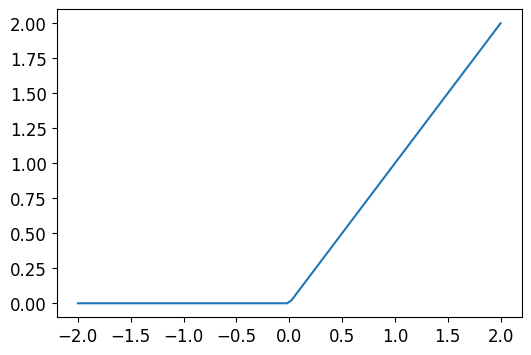

In [130]:
plot_function(F.relu)

Just like in the previous section, we can replace this code with something a bit simpler, by taking advantage of PyTorch:

In [131]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [132]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [133]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.316295,0.409270,0.505397,00:00
1,0.144465,0.228177,0.802257,00:00
2,0.079942,0.113556,0.918057,00:00
3,0.052700,0.076578,0.941609,00:00
4,0.040184,0.059732,0.956330,00:00
5,0.033820,0.050345,0.964671,00:00
6,0.030183,0.044462,0.965653,00:00
7,0.027839,0.040477,0.966634,00:00
8,0.026168,0.037594,0.968597,00:00
9,0.024878,0.035408,0.969087,00:00


We're not showing the 40 lines of output here to save room; the training process is recorded in learn.recorder, with the table of output stored in the values attribute, so we can plot the accuracy over training as:

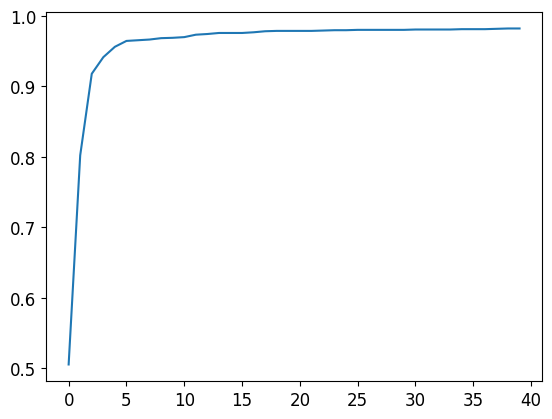

In [134]:
plt.plot(L(learn.recorder.values).itemgot(2));

and we can view accuracy

In [135]:
learn.recorder.values[-1][2]

0.98233562707901

And thats it, digit classifier from scratch

# Questions and Answers

1. How is a grayscale image represented on a computer? How about a color image?
  -  In grayscale images, the Red, Green, and Blue (RGB) channels are equal for each pixel. This equal intensity across all color channels is what gives us shades of gray. When these channels increase or decrease at the same rate, the image remains in grayscale. This means that each pixel can have a value of 0 to 255 (since these values can be transfered to each rgb value). However to represent rgb, each pixel must keep track of 3 different values, and they can have varying intensities to represent each color. Therefor you can represent each image of 28 x 28 pixels as a 2d tensor of (28,28), which flattened as a 1d tensor (28*28,1), for each of the 784 pixels there is 1 intensity number (0-255). However for rgb of the same image dimension, each of the 784 pixels have 3 intensities of rgb respectively. So the 2d tensor is (28,28,3).

2. How are the files and folders in the MNIST_SAMPLE dataset structured? Why?
  - The different numbers are split into various folders which serve different uses
    - Training set contains all the images which we train our model on
    - validation set is used to train for accuracy, how well our model can classify data it hasn't seen before  

3. Explain how the "pixel similarity" approach to classifying digits works.
  -  this works by taking all of the images in the training set, representing the image into a n x n tensor of pixel intensities in grayscale. Then creating an 'ideal' 7 or 3 by stacking all of the 3 tensors and 7 tensors separately, then averaging the pixel intensities of each pixel in the two stacks. This gives the average pixel intensity which will reveal a fuzzy 7 or 3 which averages the features of all of the images. Then we compare the images in the validation set with the ideal 3 or 7 by calculating the MSE or absolute differences (l1 norm and l2 norm) of all of the pixels. It determines if its a 3 or 7 by seeing which ideal number its closest to (smallest average distance between each pixel).


4. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
  - List comprehension is like array.map in javascript where we iterate over a list and perform an action if a preset condition is met
    

```
# let num = [1,2,3,4,5,6,7,8,9]
  doubled_odds = [x * 2 for x in num if x%2 == 1]
```


5. What is a "rank-3 tensor"?
  - A rank 3 tensor is a 3 dimensional matrix. it has 3 'dimensions' and is one dimension above a 2d tensor. Stacking many 2d tensors creates a 3d tensor. One such example of a rank 3 tensor is
    - (28,28,500) where there is 500 separate 2d tensors of size 28,28 which can represent 500 images of 28 by 28 pixels.

6. What is the difference between tensor rank and shape? How do you get the rank from the shape?
  - The rank refers to how many axes or dimensions each tensor has (3,2,4) is a rank 3 tensor. The shape refers to the size of each dimension. To get the rank you count up how many axes the tensor has. rank 3 is a stack of 2d, 2d is a tensor of colums and rows, 1d is just 1 row, and 0d is a scalar or 1 single number.

7. What are RMSE and L1 norm?
  - RMSE and l1 norm is a way to calculate accuracy. For rmse the formula is to take the sum of the square of the difference of two numbers in a list, divide it by the amount of items, then square the result. This is done to emohasize small differences. This is l2 norm. l1 norm is the absolute mean difference which takes the differences of two numbers in a list, and then takes the absolute value. This is more robust to outliers than l2 norm. These are two methods in calculating the loss of a model in linear regression.

8. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
  - For example when adding two matrices, we need to do matrix addition in which using pure python involves using for loops to iterate over the colums and rows. Pytorch is able to perform this iterative process in parallel by utilizing vectorized operations performs thousands of operations at once, and using the power of the gpu which is meant for parallel computation. gpus are powerful for these types of parallel operations.

9. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.

```
x = torch.tensor([1,2,3],
                 [4,5,6],
                 [7,8,9])
x = x * 2

x = ( [2,4,6],
     [8,10,12],
     [14,16,18])

sub_x = x[1:,1:]

print(sub_x)

[10,12,
16,18]

```

python indexes by row then column, so it says select all rows from 1 onwards, and select only from the first column onwards

10. What is broadcasting?
  - lets say you have a stack of 2d vectors (rank 3 vector), and you want to add another 2d vector to each 2d vector in the rank 3 stack. Instead of doing a for loop and iterating over each 2d vector in the rank 3 vector and doing the calculation, you can virtually clone the 2d vector to match the width of the rank 3 vector, then do the calculation in parallel. this is more efficient. Thus you are able to add vectors of varying sizes.

10. What is broadcasting?
  - lets say you have a stack of 2d vectors (rank 3 vector), and you want to add another 2d vector to each 2d vector in the rank 3 stack. Instead of doing a for loop and iterating over each 2d vector in the rank 3 vector and doing the calculation, you can virtually clone the 2d vector to match the width of the rank 3 vector, then do the calculation in parallel. this is more efficient. Thus you are able to add vectors of varying sizes.

10. What is broadcasting?
  - lets say you have a stack of 2d vectors (rank 3 vector), and you want to add another 2d vector to each 2d vector in the rank 3 stack. Instead of doing a for loop and iterating over each 2d vector in the rank 3 vector and doing the calculation, you can virtually clone the 2d vector to match the width of the rank 3 vector, then do the calculation in parallel. this is more efficient. Thus you are able to add vectors of varying sizes.

10. What is SGD?
  - stochastic gradient descent is when we try to use the derivative of the loss function to find the lowest point of the trough (which is an intuitive way to find the approach to minimize the loss of the model the most). We first find the gradient of the loss with respect to the weight and bias. Then we subtract this value by the same value * a step rate (or learning rate). w = w - lr * gradientw. Then we use these new parameters that are 'stepped' and run the model again, hopefully lowering the loss value each time. This is 'fitting' the model. With big datasets we use batches instead of the entire dataset, and shuffle between these batches in each epoch.

11. What are the seven steps in SGD for machine learning?
  - First we initialize parameters with random values, then we make a prediction function (model) using these random params. then we create a loss function that compares the models output with actual values. This should be a function. Then we find the derivative of the loss function (gradient) with respect to the params. Then we step the parameters by subtracting it with the gradient of that parameter with respect to the loss multiplied by a learning rate. Then we complete the first 5 steps until the gradient stops decreasing or we reached a desired number of epochs.
  
12. Draw the sigmoid function. What is special about its shape?
  - a sigmoid function is an s curve, and it maps any real number to a value between 0 and 1.

13. What does the DataLoader class do?
  - a dataloader is a pytorch class that allows us to easily create batches of data of specific size out of entire dataset. We can also shuffle the order of these batches.

14. Create a function that, if passed two arguments [1,2,3,4] and 'abcd', returns [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]. What is special about that output data structure?
    - dset = list(zip([1,2,3,4],[a,b,c,d]))
      - the output is a tuple, it can be useful in pairing values and labels, and the contents are immutable you cannot change them once initialized.




---



Create your own implementation of Learner from scratch, based on the training loop shown in this chapter.

In [136]:
linear = nn.Linear(28*28,1)
params = list(linear.parameters())

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid() #bound predictions between 0 and 1
    return torch.where(targets==1, 1-predictions, predictions).mean()

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean() #mean accuracy of each batch of 256 images

Here I do the following steps

1. I initialize the model using pytorch nn.linear and i flatten it to a 1d vector of size 28*28 (1 row of 784)

2. I store a list of the parameters in params variable
 - its an object with 2 tensors, a tensor of 784 weights, and a scalar tensor (bias)

3. I define loss function that gets smaller with correct output.
  - I pass a sigmoid function so values are bounded between 0 and 1,
    - a prediction closer to 1 predicts 3, closer to 0 predicts 7
  - targets is the label, if the label is 1, minus 1 from the prediction
    - so if prediction is close to 1 then loss will return a small number which we want
  - if the target (label) is 0, function just returns the prediction
    - if prediction is close to 0 then it accurately guessed 7, and loss will also be small

4. then i define a batch_accuracy function which tests the model with validation set. validation set is 2036 images.
  - it calls the model to make a prediction on an image, and its compared with the label. True is a valid prediction, false is a wrong prediction.

In [137]:
len(valid_dl) # 8 batches of 256 images

8

In [138]:
class Learner2:

    def __init__(self,trainingdata,model,loss,params,lr):
      self.trainingdata=trainingdata
      self.model=model
      self.loss=loss
      self.params=params
      self.lr=lr

    def calc_grad(self,xb,yb):
      prediction = self.model(xb)
      loss = mnist_loss(prediction,yb)
      loss.backward()

    def train_epoch(self):
      for xb,yb in self.trainingdata:
        self.calc_grad(xb,yb)
        for p in self.params:
          p.data-=p.grad*self.lr
          p.grad.zero_()

    def accuracy_epoch(self):
      accuracy = [batch_accuracy(self.model(xb),yb) for xb,yb in valid_dl]
      return round(torch.stack(accuracy).mean().item(), 4)


    #def fit(self,epochs)


In [139]:
three_or_seven = Learner2(dl,linear,mnist_loss,params,0.1)



model has been instantiated. lets train it

In [140]:
three_or_seven.train_epoch()
three_or_seven.accuracy_epoch()

0.5425

first training of the model accuracy is lower. keep training the model with train.epoch and watch the accuracy go higher and higher





---

